# Random Forest - Top model according to the SCPM of -5.53

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

In [5]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [6]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_ii",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [7]:
df = pd.read_csv("../../../../data/processed/partner_ii/cement-shipping.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [8]:
df_copy = df.drop(
    [
        # Properties
        "Initial setting time",
        "Blaine",
        "Sieve 32 um",
        "Sieve 45 um",
        "CS1",
        "CS3",
        "CS7",
        "Cement_Type",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [9]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [10]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [11]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -2.049 (0.209)
MAE: -1.604 (0.170)
MAPE: -0.037 (0.004)
R2: 0.619 (0.086)


******
[TEST]
******
RMSE: -2.750 (0.611)
MAE: -2.228 (0.604)
MAPE: -0.053 (0.018)
R2: 0.102 (0.523)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [12]:
# df_pred = pd.DataFrame()
# df_pred["DATE"] = dates.copy()
# df_pred["CS28"] = y.copy()
# df_pred["CS28_PRED"] = np.nan
# df_pred["SET"] = ""
# df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


# for idx, pipeline in enumerate(scores["estimator"]):
#     index_train = scores["indices"]["train"][idx]
#     index_test = scores["indices"]["test"][idx]
#     index_preds = np.concatenate([index_train, index_test])

#     # results = scores["estimator"][0].predict(x.loc[index_preds])
#     results = pipeline.predict(x.loc[index_preds])
#     df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
#     df_pred.loc[index_train, "SET"] = "TRAIN"
#     df_pred.loc[index_test, "SET"] = "TEST"
# df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [13]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [14]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2020-01-01 11:00:00+00:00,42.93,41.533847,TRAIN
1,2020-01-02 11:00:00+00:00,49.72,48.846807,TRAIN
2,2020-01-02 11:00:00+00:00,39.49,41.208682,TRAIN
3,2020-01-03 11:00:00+00:00,40.55,41.208682,TRAIN
4,2020-01-04 11:00:00+00:00,42.64,41.533847,TRAIN
...,...,...,...,...
1048,2021-12-28 11:00:00+00:00,46.44,47.734682,TEST
1049,2021-12-29 11:00:00+00:00,39.87,41.041979,TEST
1050,2021-12-30 11:00:00+00:00,36.74,41.041979,TEST
1051,2021-12-31 11:00:00+00:00,36.36,41.041979,TEST


<IPython.core.display.Javascript object>

In [15]:
df_copy_copy = df_copy.copy()
df_copy_copy["Date"] = pd.to_datetime(df_copy_copy["Date"])
df_copy_copy["Date"] = df_copy_copy["Date"].dt.tz_localize(None)

df_pred_copy = df_pred.copy()
df_pred_copy["DATE"] = pd.to_datetime(df_pred_copy["DATE"])
df_pred_copy["DATE"] = df_pred_copy["DATE"].dt.tz_localize(None)

df_copy_merge = df_copy_copy.reset_index(drop=True).merge(
    df_pred_copy.reset_index(drop=True), left_index=True, right_index=True, how="inner"
)
df_copy_merge["COMPANY"] = "Partner ii"
df_copy_merge["PLANT"] = "Partner ii"

for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_tsscv_partner_ii.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_tsscv_partner_ii.csv", index=False)

<IPython.core.display.Javascript object>

In [16]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2020-01-01 11:00:00+00:00,42.93,41.533847,TRAIN,1
1,2020-01-02 11:00:00+00:00,49.72,48.846807,TRAIN,1
2,2020-01-02 11:00:00+00:00,39.49,41.208682,TRAIN,1
3,2020-01-03 11:00:00+00:00,40.55,41.208682,TRAIN,1
4,2020-01-04 11:00:00+00:00,42.64,41.533847,TRAIN,1
...,...,...,...,...,...
1048,2021-12-28 11:00:00+00:00,46.44,47.734682,TEST,5
1049,2021-12-29 11:00:00+00:00,39.87,41.041979,TEST,5
1050,2021-12-30 11:00:00+00:00,36.74,41.041979,TEST,5
1051,2021-12-31 11:00:00+00:00,36.36,41.041979,TEST,5


<IPython.core.display.Javascript object>

In [17]:
(df_pred["SET"] == "TEST").sum()

875

<IPython.core.display.Javascript object>

In [18]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [19]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,1053.0,43.000541,3.530197,34.15,40.66,42.49,45.05,54.56


<IPython.core.display.Javascript object>

In [20]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

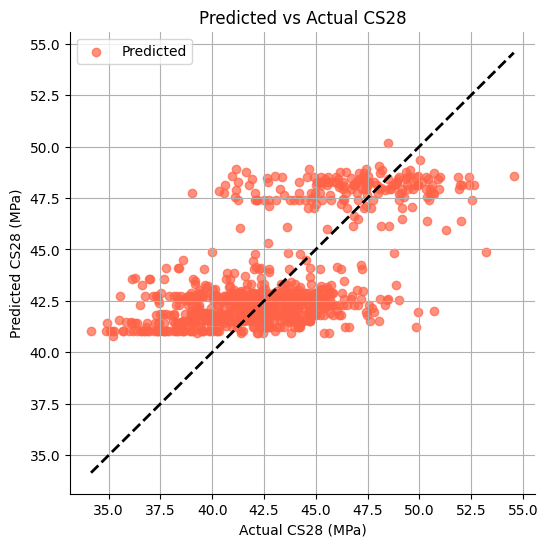

<IPython.core.display.Javascript object>

In [21]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

In [22]:
# # Time series plot of actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28"],
#     color="dodgerblue",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Actual CS28",
# )
# plt.plot(
#     test_data["DATE"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     marker="o",
#     linestyle="none",
#     label="Predicted CS28",
# )
# plt.xlabel("Date")
# plt.ylabel("CS28 (MPa)")
# plt.title("Actual vs Predicted CS28")
# plt.legend()
# plt.grid(True)

# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'

# plt.show()


<IPython.core.display.Javascript object>

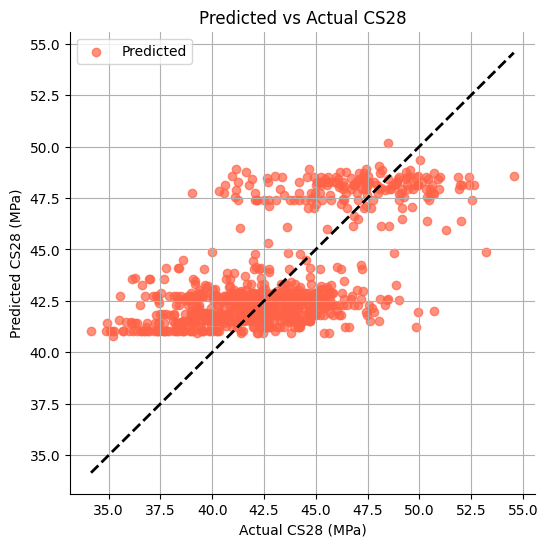

<IPython.core.display.Javascript object>

In [23]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

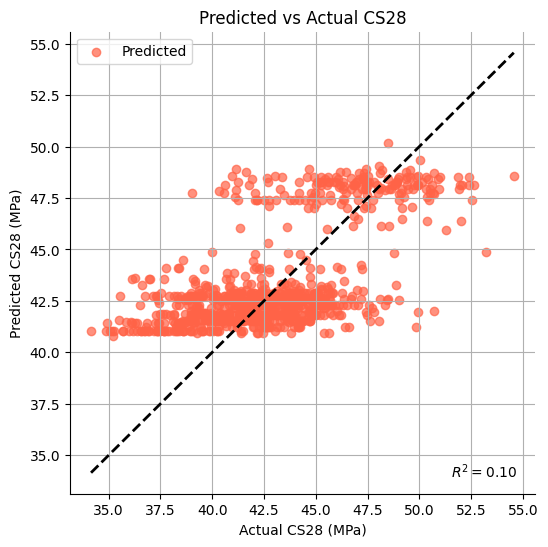

<IPython.core.display.Javascript object>

In [24]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.10
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig(
    "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()

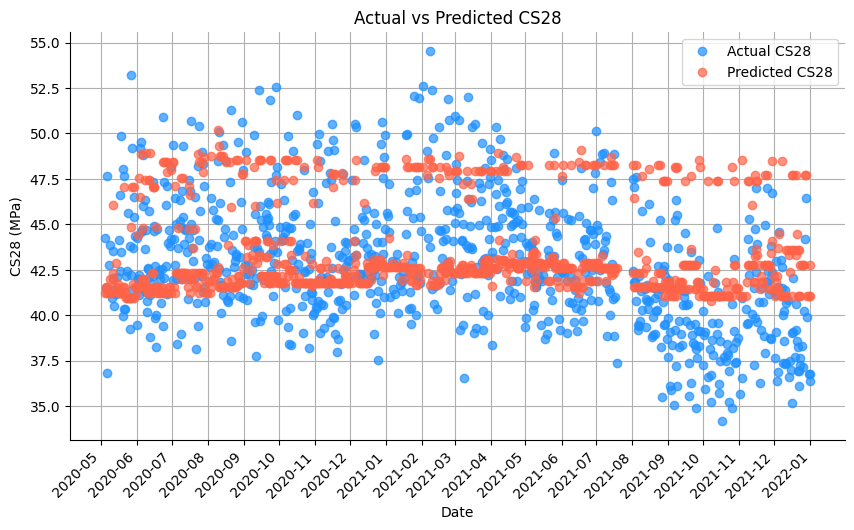

<IPython.core.display.Javascript object>

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [26]:
len(test_data), 175 * 5

(875, 875)

<IPython.core.display.Javascript object>

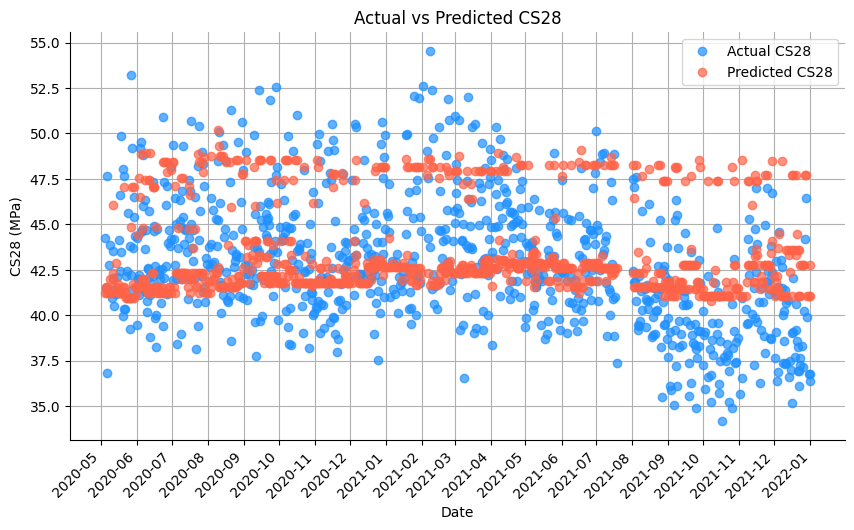

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [28]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [29]:
df_importances

,CaO,SiO2,Al2O3,Fe2O3,MgO,SO3,K2O,Na2O,Total C3S,Total C2S,C3A,C4AF,Free CaO,Loss on Ignition
Importances - 0,0.000000,0.006855,0.015926,0.005003,0.018480,0.745661,0.0,0.005212,0.000000,0.003689,0.029712,0.007892,0.002545,0.159026
Importances - 1,0.000000,0.006660,0.009796,0.000857,0.000000,0.731427,0.0,0.015337,0.000755,0.000000,0.051395,0.073506,0.006216,0.104050
Importances - 2,0.010274,0.002396,0.021561,0.037788,0.019661,0.695544,0.0,0.011101,0.015149,0.000000,0.018670,0.047059,0.000000,0.120796
Importances - 3,0.010481,0.006552,0.011823,0.002053,0.000000,0.786353,0.0,0.000887,0.030290,0.008618,0.016939,0.034275,0.000000,0.091730
Importances - 4,0.012679,0.012542,0.018389,0.000000,0.001427,0.777246,0.0,0.000000,0.060495,0.000000,0.002248,0.012197,0.000000,0.102776


<IPython.core.display.Javascript object>

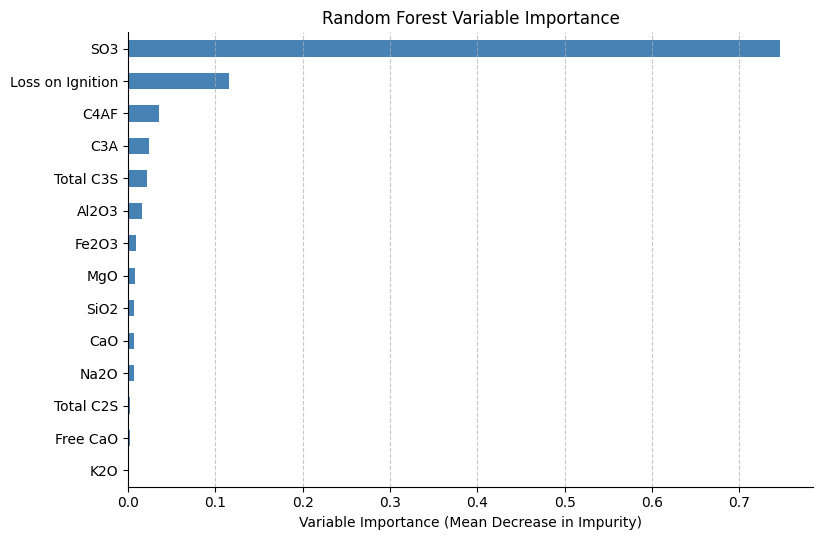

<IPython.core.display.Javascript object>

In [30]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

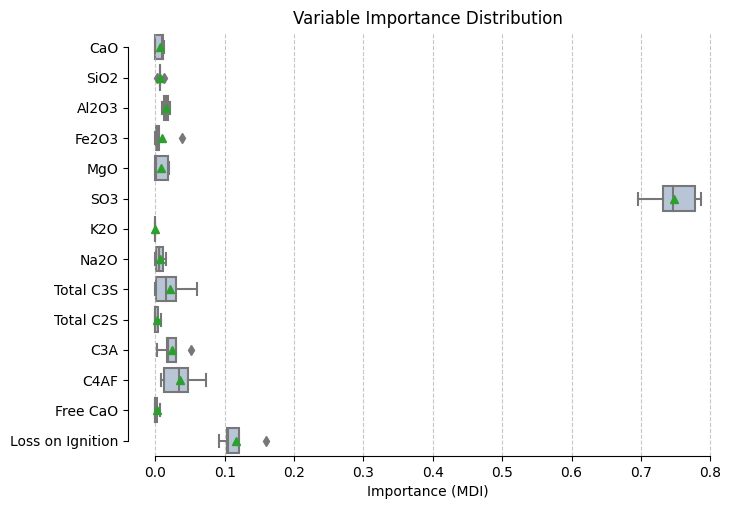

<IPython.core.display.Javascript object>

In [31]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


In [32]:
# warnings.filterwarnings("ignore")
# plt.figure(figsize=(10, 5.5))
# sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=1, showmeans=True)
# sns.despine(trim=True, left=False)
# plt.xlabel("Relevance (MDI)")
# plt.title("Variable Relevance Distribution")
# plt.grid(axis='x', linestyle='--', alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.show()


<IPython.core.display.Javascript object>

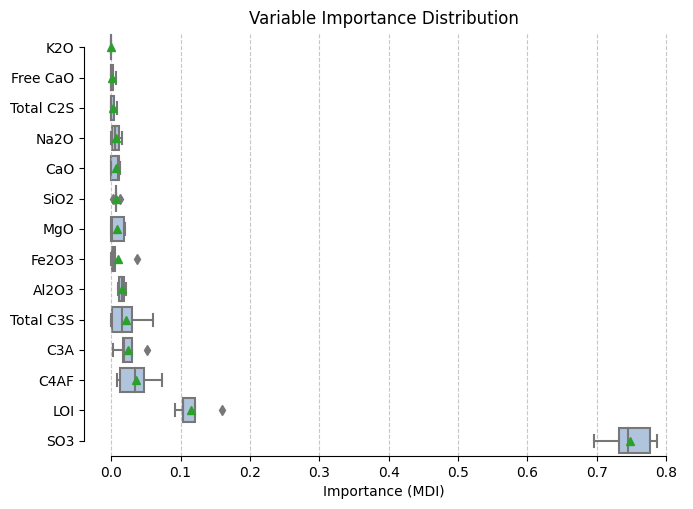

<IPython.core.display.Javascript object>

In [33]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [34]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [35]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

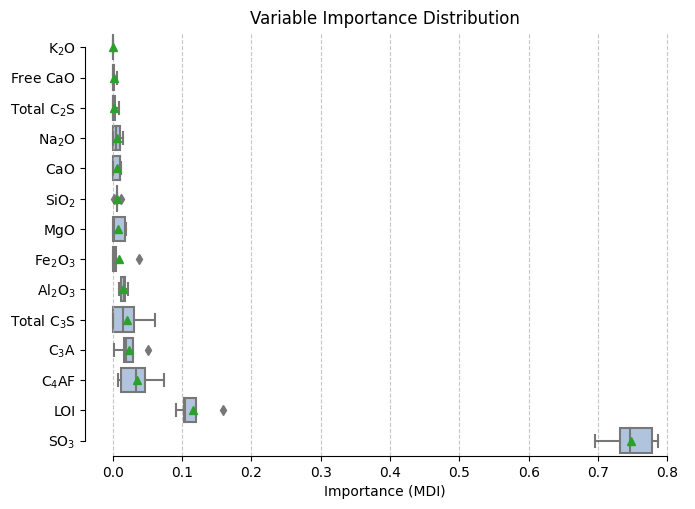

<IPython.core.display.Javascript object>

In [36]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [37]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# original_backend = plt.get_backend()

# # Switch to PGF backend to use XeLaTeX
# plt.switch_backend("pgf")

# # Update Matplotlib rcParams
# plt.rcParams.update(
#     {
#         "pgf.texsystem": "xelatex",
#         "font.family": "sans-serif",
#         "font.sans-serif": ["DejaVu Sans"],
#         "font.size": 10,
#         "font.weight": "black",
#         "axes.labelweight": "black",
#         "axes.linewidth": 1.0,
#         "xtick.labelsize": 10,
#         "ytick.labelsize": 10,
#         "text.usetex": True,
#         "pgf.preamble": r"""
#     \usepackage{fontspec}
#     \setmainfont{DejaVu Sans}[
#         UprightFont = *-Book,
#         BoldFont = *-Bold,
#     ]
#     \usepackage{mhchem}
#     \renewcommand{\seriesdefault}{\bfdefault}
#     \bfseries
#     """,
#     }
# )

# # Your plotting code
# df_importances_sorted_plot = df_importances_sorted.rename(
#     columns={
#         "K2O": r"$\ce{K2O}$",
#         "Free CaO": r"Free $\ce{CaO}$ ",
#         "Total C2S": r"Total $\ce{C2S}$",
#         "Na2O": r"$\ce{Na2O}$",
#         "CaO": r"$\ce{CaO}$",
#         "SiO2": r"$\ce{SiO2}$",
#         "MgO": r"$\ce{MgO}$",
#         "Fe2O3": r"$\ce{Fe2O3}$",
#         "Al2O3": r"$\ce{Al2O3}$",
#         "Total C3S": r"Total $\ce{C3S}$",
#         "C3A": r"$\ce{C3A}$",
#         "C4AF": r"$\ce{C4AF}$",
#         "LOI": "LOI",
#         "SO3": r"$\ce{SO3}$",
#     }
# )

# plt.figure(figsize=(10, 5.5))
# sns.boxplot(
#     data=df_importances_sorted_plot,
#     orient="h",
#     color="lightsteelblue",
#     saturation=1,
#     showmeans=True,
# )
# sns.despine(trim=True, left=False)
# plt.xlabel("Relevance (MDI)")
# plt.title("Variable Relevance Distribution")
# plt.grid(axis="x", linestyle="--", alpha=0.7)
# plt.subplots_adjust(left=0.3)
# plt.savefig(
#     "final_plot_with_xelatex.png",
#     dpi=300,
#     bbox_inches="tight",
# )


# # Step 3: Reset all rcParams to their default values
# plt.rcdefaults()

# # Switch back to the original backend
# plt.switch_backend(original_backend)

# # Now you can display the plot or continue plotting with the original backend
# plt.show()

<IPython.core.display.Javascript object>

In [38]:
df_importances

,CaO,SiO2,Al2O3,Fe2O3,MgO,SO3,K2O,Na2O,Total C3S,Total C2S,C3A,C4AF,Free CaO,Loss on Ignition
Importances - 0,0.000000,0.006855,0.015926,0.005003,0.018480,0.745661,0.0,0.005212,0.000000,0.003689,0.029712,0.007892,0.002545,0.159026
Importances - 1,0.000000,0.006660,0.009796,0.000857,0.000000,0.731427,0.0,0.015337,0.000755,0.000000,0.051395,0.073506,0.006216,0.104050
Importances - 2,0.010274,0.002396,0.021561,0.037788,0.019661,0.695544,0.0,0.011101,0.015149,0.000000,0.018670,0.047059,0.000000,0.120796
Importances - 3,0.010481,0.006552,0.011823,0.002053,0.000000,0.786353,0.0,0.000887,0.030290,0.008618,0.016939,0.034275,0.000000,0.091730
Importances - 4,0.012679,0.012542,0.018389,0.000000,0.001427,0.777246,0.0,0.000000,0.060495,0.000000,0.002248,0.012197,0.000000,0.102776


<IPython.core.display.Javascript object>

In [39]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.006687,0.006177,0.000000,0.000000,0.010274,0.010481,0.012679
SiO2,5.0,0.007001,0.003614,0.002396,0.006552,0.006660,0.006855,0.012542
Al2O3,5.0,0.015499,0.004778,0.009796,0.011823,0.015926,0.018389,0.021561
Fe2O3,5.0,0.009140,0.016126,0.000000,0.000857,0.002053,0.005003,0.037788
MgO,5.0,0.007914,0.010210,0.000000,0.000000,0.001427,0.018480,0.019661
SO3,5.0,0.747246,0.036590,0.695544,0.731427,0.745661,0.777246,0.786353
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Na2O,5.0,0.006508,0.006608,0.000000,0.000887,0.005212,0.011101,0.015337
Total C3S,5.0,0.021338,0.025153,0.000000,0.000755,0.015149,0.030290,0.060495
Total C2S,5.0,0.002461,0.003794,0.000000,0.000000,0.000000,0.003689,0.008618


<IPython.core.display.Javascript object>

In [40]:
df_importances.mean(axis=0)

CaO                 0.006687
SiO2                0.007001
Al2O3               0.015499
Fe2O3               0.009140
MgO                 0.007914
SO3                 0.747246
K2O                 0.000000
Na2O                0.006508
Total C3S           0.021338
Total C2S           0.002461
C3A                 0.023793
C4AF                0.034986
Free CaO            0.001752
Loss on Ignition    0.115675
dtype: float64

<IPython.core.display.Javascript object>

In [41]:
df_importances.std(axis=0)

CaO                 0.006177
SiO2                0.003614
Al2O3               0.004778
Fe2O3               0.016126
MgO                 0.010210
SO3                 0.036590
K2O                 0.000000
Na2O                0.006608
Total C3S           0.025153
Total C2S           0.003794
C3A                 0.018264
C4AF                0.026849
Free CaO            0.002728
Loss on Ignition    0.026365
dtype: float64

<IPython.core.display.Javascript object>

In [42]:
df_importances.std(axis=0, ddof=0)

CaO                 0.005524
SiO2                0.003233
Al2O3               0.004273
Fe2O3               0.014424
MgO                 0.009132
SO3                 0.032727
K2O                 0.000000
Na2O                0.005911
Total C3S           0.022498
Total C2S           0.003394
C3A                 0.016336
C4AF                0.024015
Free CaO            0.002440
Loss on Ignition    0.023581
dtype: float64

<IPython.core.display.Javascript object>

In [43]:
df_copy.nunique()

Date                693
CaO                 226
SiO2                182
Al2O3                89
Fe2O3                56
MgO                 178
SO3                  78
K2O                  32
Na2O                 18
Total C3S           630
Total C2S           561
C3A                 232
C4AF                224
Free CaO             98
Loss on Ignition    173
dtype: int64

<IPython.core.display.Javascript object>

In [44]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [45]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [46]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

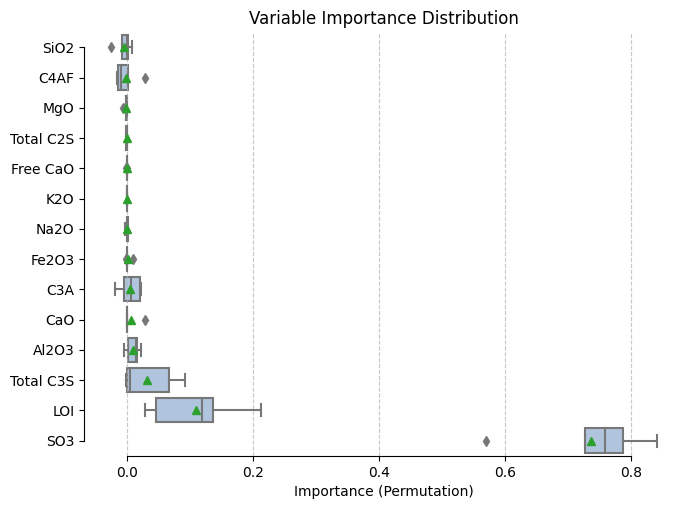

<IPython.core.display.Javascript object>

In [47]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

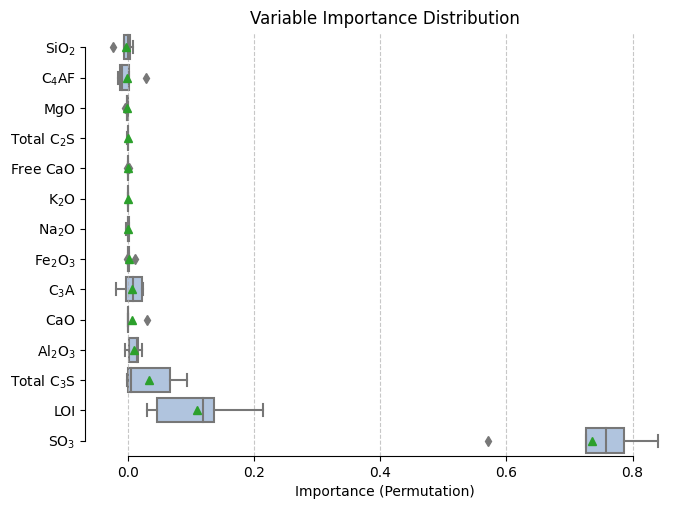

<IPython.core.display.Javascript object>

In [48]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [49]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
SiO2,5.0,-0.004110,0.012702,-0.024624,-0.007185,0.000626,0.002585,0.008048
C4AF,5.0,-0.001834,0.018040,-0.015739,-0.013151,-0.009866,0.001323,0.028264
MgO,5.0,-0.001811,0.002225,-0.005448,-0.001893,-0.001714,0.000000,0.000000
Total C2S,5.0,-0.000406,0.000579,-0.001247,-0.000781,0.000000,0.000000,0.000000
Free CaO,5.0,-0.000030,0.000865,-0.001298,0.000000,0.000000,0.000000,0.001147
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Na2O,5.0,0.000218,0.001829,-0.002606,0.000000,0.000000,0.001818,0.001878
Fe2O3,5.0,0.001910,0.004849,-0.001728,0.000000,0.000000,0.000857,0.010419
C3A,5.0,0.005855,0.017552,-0.018809,-0.003646,0.007468,0.021311,0.022949
CaO,5.0,0.006049,0.013139,0.000000,0.000000,0.000207,0.000488,0.029550


<IPython.core.display.Javascript object>

In [50]:
perm_importances_df

,SiO2,C4AF,MgO,Total C2S,Free CaO,K2O,Na2O,Fe2O3,C3A,CaO,Al2O3,Total C3S,LOI,SO3
0,-0.007185,0.001323,-0.005448,-0.001247,0.001147,0.0,0.001818,-0.001728,0.021311,0.000000,0.001308,0.000000,0.213557,0.726028
1,0.002585,-0.013151,0.000000,0.000000,-0.001298,0.0,0.001878,0.010419,-0.018809,0.000000,-0.004925,-0.001851,0.136352,0.570395
2,0.000626,0.028264,-0.001714,0.000000,0.000000,0.0,-0.002606,0.000857,0.007468,0.000207,0.016034,0.005089,0.046301,0.786860
3,0.008048,-0.009866,0.000000,-0.000781,0.000000,0.0,0.000000,0.000000,0.022949,0.000488,0.014879,0.067062,0.029695,0.757666
4,-0.024624,-0.015739,-0.001893,0.000000,0.000000,0.0,0.000000,0.000000,-0.003646,0.029550,0.022260,0.092953,0.119064,0.840340


<IPython.core.display.Javascript object>

In [51]:
perm_importances_df.mean(axis=0)

SiO2        -0.004110
C4AF        -0.001834
MgO         -0.001811
Total C2S   -0.000406
Free CaO    -0.000030
K2O          0.000000
Na2O         0.000218
Fe2O3        0.001910
C3A          0.005855
CaO          0.006049
Al2O3        0.009911
Total C3S    0.032651
LOI          0.108994
SO3          0.736258
dtype: float64

<IPython.core.display.Javascript object>

In [52]:
perm_importances_df.std(axis=0, ddof=0)

SiO2         0.011361
C4AF         0.016136
MgO          0.001990
Total C2S    0.000518
Free CaO     0.000774
K2O          0.000000
Na2O         0.001636
Fe2O3        0.004337
C3A          0.015699
CaO          0.011752
Al2O3        0.010087
Total C3S    0.039589
LOI          0.066335
SO3          0.091068
dtype: float64

<IPython.core.display.Javascript object>

In [53]:
# fig, ax = plt.subplots(figsize=(12, 8))
# ax.barh(importances_df["Feature"], importances_df["Permutation Importance Mean"], xerr=importances_df["Permutation Importance Std"], color="salmon", alpha=0.7, label="Permutation Importance")
# ax.set_title("Feature Importance: MDI vs Permutation with Standard Deviation")
# ax.set_xlabel("Importance Score")
# ax.legend()
# plt.tight_layout()
# plt.show()


<IPython.core.display.Javascript object>

# Top one dominant model - Transformer 1 TS

In [54]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Time
import time

# Random and os for reproducibility
import random
import os

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
import tensorflow as tf

# Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Making keras compatible with scikit learn api
# https://scikit-learn.org/stable/developers/develop.html
from sklearn.base import BaseEstimator, RegressorMixin

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Converting Times Series Data to 3D format
from src.utils.split_sequences import split_sequences

# Transformer Encoder for time series data
from src.models.transformer_ts_tf import Transformer

2025-04-05 17:40:32.409392: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-05 17:40:32.411608: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 17:40:32.466259: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-05 17:40:32.466798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-05 17:40:33.459005: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

<IPython.core.display.Javascript object>

## Functions and definitions

### Convert train/test data to 3D format

In [55]:
def generate_sequences_helper(
    dataset, cement_types, dates=None, timesteps=None, split_by_cement_type=False
):
    index_train = dataset["y_train"].index
    index_test = dataset["y_test"].index

    dataset["y_train"] = dataset["y_train"].reset_index(drop=True)
    dataset["y_test"] = dataset["y_test"].reset_index(drop=True)

    if dates is not None:
        dataset["dates_train"] = dates[index_train].reset_index(drop=True)
        dataset["dates_test"] = dates[index_test].reset_index(drop=True)

    dataset["cement_types_train"] = cement_types.loc[index_train].reset_index(drop=True)
    dataset["cement_types_test"] = cement_types.loc[index_test].reset_index(drop=True)

    dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

    return dataset

<IPython.core.display.Javascript object>

In [56]:
def generate_sequences(dataset, timesteps, split_by_cement_type=False):
    if split_by_cement_type:
        dataset["x_train"], dataset["y_train"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_train"],
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["cement_types_train"],
                    dataset["y_train"],
                ],
                axis=1,
            ),
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences_per_cement_type(
            pd.concat(
                [
                    dataset["dates_test"],
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["cement_types_test"],
                    dataset["y_test"],
                ],
                axis=1,
            ),
            timesteps,
        )
    else:
        dataset["x_train"], dataset["y_train"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_train"], columns=x.columns),
                    dataset["y_train"],
                ],
                axis=1,
            ).values,
            timesteps,
        )

        dataset["x_test"], dataset["y_test"] = split_sequences(
            pd.concat(
                [
                    pd.DataFrame(dataset["x_test"], columns=x.columns),
                    dataset["y_test"],
                ],
                axis=1,
            ).values,
            timesteps,
        )
    return dataset

<IPython.core.display.Javascript object>

In [57]:
def impute_data(dataset, imputer=None, imputer_params=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply imputation to the data
    if imputer is not None:
        imputer = imputer() if imputer_params is None else imputer(**imputer_params)
        x_train = imputer.fit_transform(x_train)
        x_test = imputer.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return imputer, dataset

<IPython.core.display.Javascript object>

In [58]:
def transform_data(dataset, transformer=None):
    x_train = dataset["x_train"]
    x_test = dataset["x_test"]

    # Apply data normalization/standardization to the data
    if transformer is not None:
        scaler = transformer()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

    dataset["x_train"] = x_train
    dataset["x_test"] = x_test

    return scaler, dataset

<IPython.core.display.Javascript object>

In [59]:
def preprocess_data(dataset, transformer=None, imputer=None, imputer_params=None):
    imputer, dataset = impute_data(dataset, imputer, imputer_params)
    scaler, dataset = transform_data(dataset, transformer)
    return imputer, scaler, dataset

<IPython.core.display.Javascript object>

### Train and evaluate the model

In [60]:
def train_and_evaluate_model(Estimator, dataset, estimator_params=None):
    """
    Purpose: Helper function to be used in conjunction with
    blocked time_series cross validation function
    """
    x_train = dataset["x_train"]
    y_train = dataset["y_train"]
    x_test = dataset["x_test"]
    y_test = dataset["y_test"]

    # Instantiate the model
    model = Estimator() if estimator_params is None else Estimator(**estimator_params)

    # Fitting the model
    model.fit(x_train, y_train)

    # Making predictions on train/test sets
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Return regression metrics
    return model, score_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

<IPython.core.display.Javascript object>

### Custom Cross Validate

In [61]:
# def custom_cross_validate(
#     Estimator,
#     Imputer,
#     Transform,
#     x,
#     y,
#     cv,
#     timesteps,
#     dates=None,
#     cement_types=None,
#     estimator_params=None,
#     imputer_params=None,
#     split_by_cement_type=True,
# ):
#     results = []
#     scores = []
#     scores_estimators_and_indexes = {
#         "pipeline": [],
#         "indices": {"train": [], "test": []},
#     }

#     for train_index, test_index in cv.split(x):
#         dataset = {
#             "dates_train": dates[train_index].reset_index(drop=True),
#             "cement_types_train": cement_types.loc[train_index].reset_index(drop=True),
#             "x_train": x.loc[train_index].reset_index(drop=True),
#             "y_train": y[train_index].reset_index(drop=True),
#             "dates_test": dates[test_index].reset_index(drop=True),
#             "cement_types_test": cement_types.loc[test_index].reset_index(drop=True),
#             "x_test": x.loc[test_index].reset_index(drop=True),
#             "y_test": y[test_index].reset_index(drop=True),
#         }

#         # Preprocess the dataset
#         imputer, scaler, dataset = preprocess_data(
#             dataset, Transform, Imputer, imputer_params
#         )

#         # generate sequences (3D format)
#         dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

#         # Train and Evaluate the model
#         estimator, score = train_and_evaluate_model(
#             Estimator, dataset, estimator_params
#         )
#         scores.append(score)
#         scores_estimators_and_indexes["pipeline"].append([imputer, scaler, estimator])
#         scores_estimators_and_indexes["indices"]["train"].append(train_index)
#         scores_estimators_and_indexes["indices"]["test"].append(test_index)

#     # After every iteration metrics results are appended together
#     scores_final = {key: [] for key, _ in scores[0].items()}
#     for scores_dict in scores:
#         for key, value in scores_dict.items():
#             scores_final[key] += [value]
#     results.append(scores_final)
#     return scores_estimators_and_indexes, results

<IPython.core.display.Javascript object>

In [62]:
def custom_cross_validate(
    Estimator,
    Imputer,
    Transform,
    x,
    y,
    cv,
    timesteps,
    dates=None,
    cement_types=None,
    estimator_params=None,
    imputer_params=None,
    split_by_cement_type=True,
):
    scores = []
    pipelines = []
    indices = {"train": [], "test": []}

    for train_index, test_index in cv.split(x):
        dataset = {
            "dates_train": dates.iloc[train_index].reset_index(drop=True),
            "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
            "x_train": x.iloc[train_index].reset_index(drop=True),
            "y_train": y.iloc[train_index].reset_index(drop=True),
            "dates_test": dates.iloc[test_index].reset_index(drop=True),
            "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
            "x_test": x.iloc[test_index].reset_index(drop=True),
            "y_test": y.iloc[test_index].reset_index(drop=True),
        }

        # Preprocess the dataset
        imputer, scaler, dataset = preprocess_data(
            dataset, Transform, Imputer, imputer_params
        )

        # Generate sequences (3D format)
        dataset = generate_sequences(dataset, timesteps, split_by_cement_type)

        # Train and Evaluate the model
        estimator, score = train_and_evaluate_model(
            Estimator, dataset, estimator_params
        )
        scores.append(score)
        pipelines.append((imputer, scaler, estimator))
        indices["train"].append(train_index)
        indices["test"].append(test_index)

    return pipelines, indices, scores

<IPython.core.display.Javascript object>

## Model Definition

In [63]:
class TransformerWrapper(RegressorMixin):
    def __init__(self, params):
        self.params = params
        self.model = self.get_model()
        self.batch_size = 16
        self.epochs = 300
        self.verbose = 0

    def fit(self, X=None, y=None):
        self.model.fit(
            X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=self.verbose
        )

    def predict(self, X=None):
        return self.model.predict(X, verbose=self.verbose)

    def get_model(self):
        model = Transformer(
            num_hid=self.params["num_features"],
            time_steps=self.params["timesteps"],
            num_head=self.params["num_heads"],
            num_layers_enc=self.params["num_layers_enc"],
            num_feed_forward=self.params["num_feed_forward"],
        )
        model.compile(
            tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
        )
        return model

<IPython.core.display.Javascript object>

In [64]:
def pad_time_series(dataframe, timesteps):
    """
    Pad timeseries with zeros
    """
    df_tmp = pd.DataFrame(
        dict(
            zip(
                dataframe.columns,
                [[0 for _ in range(timesteps - 1)] for _ in range(dataframe.shape[1])],
            )
        )
    )
    df_tmp[DATE] = dataframe[DATE].iloc[0]
    return pd.concat([df_tmp, dataframe], axis=0).reset_index(drop=True)

<IPython.core.display.Javascript object>

In [65]:
def split_sequences_per_cement_type(dataframe, timesteps, pad=False):
    """
    Create sequences per cement time
    to avoid having parts of the sequence
    of different types of cement.
    """
    if timesteps == 1:
        return split_sequences(
            dataframe.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps
        )

    dates = dataframe[DATE][timesteps - 1 :]
    data = []
    dataframes = []

    for cement_type in CEMENT_TYPES:
        data.append(dataframe[dataframe[cement_type] == 1])
    data.append(dataframe[(dataframe[CEMENT_TYPES] == 0).all(axis=1)])

    for df in data:
        if pad:
            dates = df[DATE].reset_index(drop=True)
            df = pad_time_series(df, timesteps).reset_index(drop=True)
        else:
            dates = df[DATE][timesteps - 1 :].reset_index(drop=True)
        x, y = split_sequences(df.drop([DATE] + CEMENT_TYPES, axis=1).values, timesteps)
        x = pd.DataFrame({"Sequences": [sample.tolist() for sample in x]})
        y = pd.DataFrame({"Target": y})
        dataframes.append(pd.concat([dates, x, y], axis=1))

    data = pd.concat(dataframes, axis=0)
    data[DATE] = pd.to_datetime(data[DATE])
    data = data.sort_values(by=DATE).reset_index(drop=True)
    x = data["Sequences"]
    y = data["Target"].values
    x = np.array(x.tolist())

    return x, y

<IPython.core.display.Javascript object>

In [66]:
def merge_dicts(dicts):
    """Merges dicts in a list, preserving multiple values for each key.

    Args:
        dicts (list): The list of dicts to merge.

    Returns:
        list: A list of merged dicts.
    """

    merged_dicts = {}
    for d in dicts:
        for key, value in d.items():
            merged_dicts.setdefault(key, []).append(value)
    return merged_dicts

<IPython.core.display.Javascript object>

# Settings for Reproducibility

In [67]:
def set_seeds():
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ["PYTHONHASHSEED"] = str(SEED)
    tf.random.set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)


# https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed

<IPython.core.display.Javascript object>

In [68]:
def set_global_determinism():
    set_seeds(seed=SEED)

    os.environ["TF_DETERMINISTIC_OPS"] = "1"
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

<IPython.core.display.Javascript object>

In [69]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}
DATE = "Date"
CEMENT_TYPES = ["cem_type_CEM B", "cem_type_CEM C"]

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [70]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "partner_iv",
    "Features": "Chemical + Mineralogical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Transformer",
    "Model Params": None,
    "Scaler": "Standard Scaler",
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [71]:
df = pd.read_csv("../../../../data/processed/partner_iv/cement-shipping.csv")

<IPython.core.display.Javascript object>

In [72]:
df_copy = df.drop(
    [
        # Properties
        "Blaine",
        "ph2oimm",  # Maybe pH of the immersion liquid | pH (acidity or alkalinity)
        "Initial Setting Time",
        "flow",  # Maybe flow table test
        "residuo 24 micron",  # Maybe the residue left after passing the material through a sieve
        "R_wp",  # Maybe water to powder ratio
        "CS2",  # 2-day Compressive Strength
        "Soundness",
    ],
    axis=1,
).copy()

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_copy</h2> <br>In this dataset all features are used.

In [73]:
df_copy[CEMENT_TYPES] = df_copy[CEMENT_TYPES].astype(int)
dates = df["Date"].copy()
y = df_copy.pop("CS28")
x = df_copy
df_copy = pd.concat([x, y], axis=1)

<IPython.core.display.Javascript object>

In [74]:
TIMESTEPS_LIST = [1]

<IPython.core.display.Javascript object>

# Transformer Encoder

# Configs:

1. TIMESTEPS: 1, 3, 5, 7, 10, 15, 20

2. Epochs: 300

3. Batch size: 16

4. num heads: 1

5. FF Layers enc: 1

      5.1 Units 16

6. Optimization Algorithm: Adam
    
    6.1. Learning Rate: 1e-3

In [75]:
params = {}
params["timesteps"] = None
params["num_features"] = None
params["num_heads"] = 1
params["num_layers_enc"] = 1
params["num_feed_forward"] = 16

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

The training set has size i * n_samples // (n_splits + 1) + n_samples % (n_splits + 1) in the i th split, with a test set of size n_samples//(n_splits + 1) by default, where n_samples is the number of samples.


<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>10<br>    
    1. Train: 10 folds of 114, 226, 338, 450, 562, 675, 787, 899, 1011, 1123 samples each fold
    2. Test: 112 samples each fold
<b>Total:</b> 10 models<br>

In [76]:
# set_seeds()
# start = time.time()
# gap = 0
# n_splits = 5
# repeats = 3
# TIMESTEPS_LIST = [1]
# scores_estimators_and_indexes_final =

# print("Blocking Time Series Split:")
# print(f"Repeats: {repeats}")
# print(f"n_splits: {n_splits}")
# print()

# for timesteps in TIMESTEPS_LIST:
#     set_seeds()
#     scores_final = None
#     params["timesteps"] = timesteps

#     for _ in range(repeats):
#         x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
#         y = df_copy["CS28"]
#         params["num_features"] = x.shape[-1]

#         cv = TimeSeriesSplit(
#             gap=gap, max_train_size=None, n_splits=n_splits, test_size=None
#         )
#         scores_estimators_and_indexes, scores = custom_cross_validate(
#             TransformerWrapper,
#             SimpleImputer,
#             StandardScaler,
#             x,
#             y,
#             cv,
#             timesteps,
#             dates=dates,
#             cement_types=df_copy[CEMENT_TYPES],
#             estimator_params={"params": params},
#             imputer_params={"strategy": "median"},
#         )
#         scores = scores[0]
#         if scores_final is None:
#             scores_final = {key: [] for key, _ in scores.items()}

#         for key, value in scores.items():
#             scores_final[key] += [value]

#     print("TIMESTEPS: %d " % timesteps)
#     print_scores(scores_final, METRICS, METRICS_DICT)

#     # Saving the results
#     scores = {key: np.array(val).flatten() for key, val in scores_final.items()}
#     results_dict_copy = results_dict.copy()
#     results_dict_copy["Timesteps"] = timesteps
#     results_dict_copy["Cross Validation"] = "Time Series Split"
#     results_dict_copy[
#         "Cross Validation Params"
#     ] = '{"N_Splits": 5, "Repeats": 3, "Gap": 0}'
#     results_dict_copy["Data Shape"] = x.shape
#     df_results = fill_results_dict(results_dict_copy, scores)
#     results_to_save.append(df_results)

# end = time.time()
# print("Minutes Elapsed: ", (end - start) / 60)

<IPython.core.display.Javascript object>

In [77]:
set_seeds()
start = time.time()
gap = 0
n_splits = 5
repeats = 3
TIMESTEPS_LIST = [1]
timesteps = 1

print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()

pipelines_final = []
indices_final = {"train": [], "test": []}
scores_final = []


for _ in range(repeats):
    x = df_copy.drop(["Date", "CS28"] + CEMENT_TYPES, axis=1)
    y = df_copy["CS28"]
    params["num_features"] = x.shape[-1]

    cv = TimeSeriesSplit(
        gap=gap, max_train_size=None, n_splits=n_splits, test_size=None
    )
    pipelines, indices, scores = custom_cross_validate(
        TransformerWrapper,
        SimpleImputer,
        StandardScaler,
        x,
        y,
        cv,
        timesteps,
        dates=dates,
        cement_types=df_copy[CEMENT_TYPES],
        estimator_params={"params": params},
        imputer_params={"strategy": "median"},
    )

    # Collect results
    pipelines_final.extend(pipelines)
    indices_final["train"].extend(indices["train"])
    indices_final["test"].extend(indices["test"])
    scores_final.extend(scores)

scores_merged = merge_dicts(scores)
print("TIMESTEPS: %d " % timesteps)
print_scores(scores_merged, METRICS, METRICS_DICT)

end = time.time()
print("Minutes Elapsed: ", (end - start) / 60)

Blocking Time Series Split:
Repeats: 3
n_splits: 5



2025-04-05 17:40:38.044217: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-05 17:40:38.044268: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: inspirada
2025-04-05 17:40:38.044278: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: inspirada
2025-04-05 17:40:38.044469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.183.1
2025-04-05 17:40:38.044504: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.183.1
2025-04-05 17:40:38.044513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.183.1


TIMESTEPS: 1 
******
[TRAIN]
******
RMSE: 2.135 (0.347)
MAE: 1.565 (0.270)
MAPE: 0.033 (0.006)
R2: 0.891 (0.038)


******
[TEST]
******
RMSE: 3.444 (0.403)
MAE: 2.711 (0.368)
MAPE: 0.056 (0.009)
R2: 0.711 (0.079)


Minutes Elapsed:  12.090290387471518


<IPython.core.display.Javascript object>

In [78]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences(dataset, params["timesteps"], split_by_cement_type=True)

    # Adjust dates for sequences
    dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
    dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"]).flatten()
    y_test_pred = estimator.predict(dataset["x_test"]).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

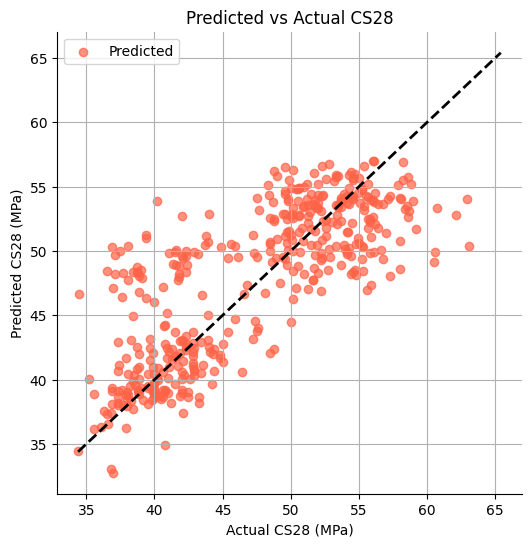

<IPython.core.display.Javascript object>

In [79]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data = test_data.groupby("DATE", as_index=False).agg(
    {"CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
)
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [df_pred["CS28"].min(), df_pred["CS28"].max()],
    [df_pred["CS28"].min(), df_pred["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28.png", dpi=300, bbox_inches="tight"
)
plt.show()


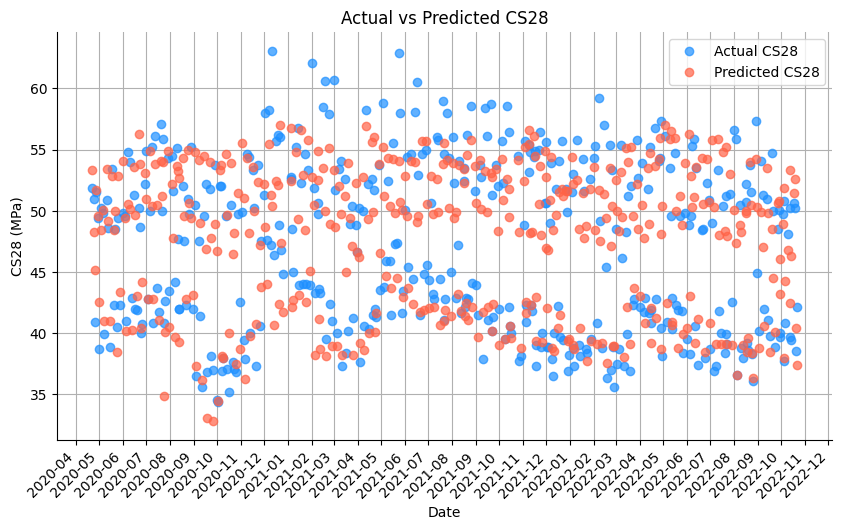

<IPython.core.display.Javascript object>

In [80]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [81]:
# Store predictions for each fold
all_predictions = []
cement_types=df_copy[CEMENT_TYPES]
params["timesteps"]=timesteps

for idx, (imputer, scaler, estimator) in enumerate(pipelines_final):
    train_index = indices_final["train"][idx]
    test_index = indices_final["test"][idx]
    
    # Prepare dataset for prediction
    dataset = {
        "dates_train": dates.iloc[train_index].reset_index(drop=True),
        "cement_types_train": cement_types.iloc[train_index].reset_index(drop=True),
        "x_train": x.iloc[train_index].reset_index(drop=True),
        "y_train": y.iloc[train_index].reset_index(drop=True),
        "dates_test": dates.iloc[test_index].reset_index(drop=True),
        "cement_types_test": cement_types.iloc[test_index].reset_index(drop=True),
        "x_test": x.iloc[test_index].reset_index(drop=True),
        "y_test": y.iloc[test_index].reset_index(drop=True),
    }

    # Apply preprocessing
    dataset["x_train"] = imputer.transform(dataset["x_train"])
    dataset["x_test"] = imputer.transform(dataset["x_test"])

    dataset["x_train"] = scaler.transform(dataset["x_train"])
    dataset["x_test"] = scaler.transform(dataset["x_test"])

    # Generate sequences
    dataset = generate_sequences(dataset, params["timesteps"], split_by_cement_type=True)

    # Adjust dates for sequences
    dates_train = dataset["dates_train"][params["timesteps"] - 1:].reset_index(drop=True)
    dates_test = dataset["dates_test"][params["timesteps"] - 1:].reset_index(drop=True)

    # Make predictions
    y_train_pred = estimator.predict(dataset["x_train"]).flatten()
    y_test_pred = estimator.predict(dataset["x_test"]).flatten()

    # Store predictions along with fold information
    fold_predictions_train = pd.DataFrame({
        "DATE": dates_train,
        "CS28": dataset["y_train"],
        "CS28_PRED": y_train_pred,
        "SET": ["TRAIN"] * len(y_train_pred),
        "FOLD": [idx + 1] * len(y_train_pred),
        "REPEAT": [(idx) // 5] * len(y_train_pred),
    })

    fold_predictions_test = pd.DataFrame({
        "DATE": dates_test,
        "CS28": dataset["y_test"],
        "CS28_PRED": y_test_pred,
        "SET": ["TEST"] * len(y_test_pred),
        "FOLD": [idx + 1] * len(y_test_pred),
        "REPEAT": [(idx) // 5] * len(y_test_pred),
    })

    all_predictions.append(pd.concat([fold_predictions_train, fold_predictions_test], axis=0))


<IPython.core.display.Javascript object>

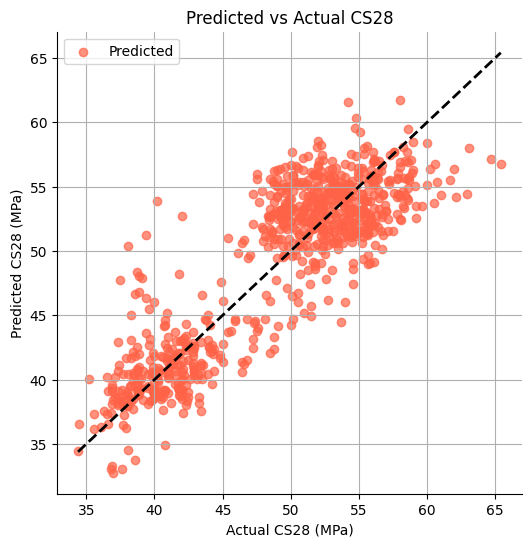

<IPython.core.display.Javascript object>

In [82]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [
        test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
    ],
    axis=1,
).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

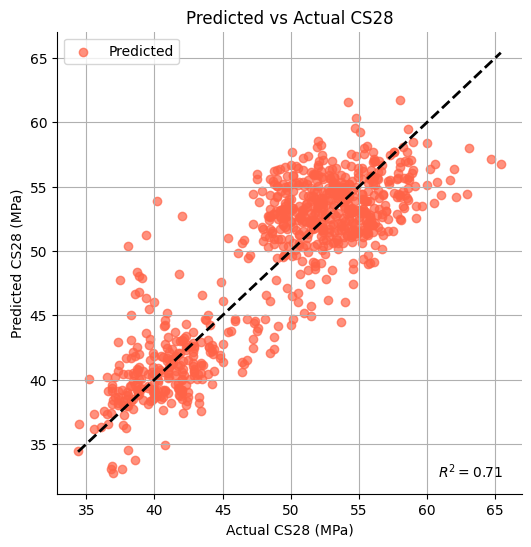

<IPython.core.display.Javascript object>

In [83]:
df_pred = pd.concat(all_predictions).reset_index(drop=True)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# Proceed with your plotting code
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]

test_data_tmp = test_data[test_data["REPEAT"].eq(0)].copy().reset_index(drop=True)

mean = pd.concat(
    [
        test_data[test_data["REPEAT"].eq(0)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(1)]["CS28_PRED"].reset_index(drop=True),
        test_data[test_data["REPEAT"].eq(2)]["CS28_PRED"].reset_index(drop=True),
    ],
    axis=1,
).mean(axis=1)

test_data_tmp["CS28_PRED"] = mean
test_data = test_data_tmp

# test_data = test_data.groupby("INDEX", as_index=False).agg(
#     {"DATE": "first", "CS28": "first", "CS28_PRED": "mean", "SET": "first", "FOLD": "first"}
# )
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.71
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig(
    "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

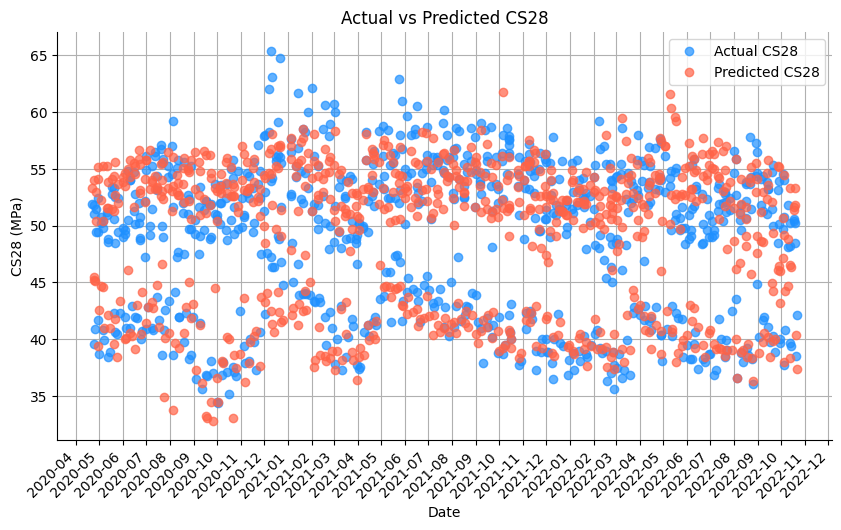

<IPython.core.display.Javascript object>

In [84]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "inn_cm_tiss_dominant_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [85]:
def compute_scmp(y_true, y_pred):
    # Compute the performance metrics
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    # Create a DataFrame with these metrics
    metrics_df = pd.DataFrame(
        {"RMSE Test": [rmse], "MAE Test": [mae], "MAPE Test": [mape], "R2 Test": [r2]}
    )

    # Standardize the metrics
    scaler = StandardScaler(with_mean=False)
    standardized_metrics = scaler.fit_transform(metrics_df)

    # Creating a new DataFrame with standardized values
    standardized_df = pd.DataFrame(
        standardized_metrics,
        columns=["RMSE Test", "MAE Test", "MAPE Test", "R2 Test"],
    )

    # Compute SCPM: sum errors and subtract R2
    scpm = (
        standardized_df["RMSE Test"]
        + standardized_df["MAE Test"]
        + standardized_df["MAPE Test"]
        - standardized_df["R2 Test"]
    )

    return scpm.iloc[0]  # Return the scalar SCPM score

<IPython.core.display.Javascript object>

In [86]:
def permutation_importance_seq(model, X, y, metric, n_repeats=5):
    """
    Computes permutation importance for sequence models with 3D input.
    """
    baseline_score = metric(y, model.predict(X))
    num_features = X.shape[2]  # Number of features
    importances = np.zeros(num_features)
    set_seeds()
    for i in range(num_features):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            # Shuffle feature i across samples, keeping time steps intact
            for t in range(X.shape[1]):
                # Extract the feature values at time t
                feature_values = X_permuted[:, t, i]
                np.random.shuffle(feature_values)
                X_permuted[:, t, i] = feature_values
            # Compute metric with permuted data
            permuted_score = metric(y, model.predict(X_permuted))
            scores.append(permuted_score)
        # Importance is the increase in metric when the feature is permuted
        importances[i] = baseline_score - np.mean(scores)
    return importances

<IPython.core.display.Javascript object>

In [87]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from tqdm import tqdm

feature_importances = []

for idx, (imputer, scaler, estimator) in tqdm(enumerate(pipelines_final)):
    train_index = indices_final["train"][idx]
    x_train = x.iloc[train_index].reset_index(drop=True)
    y_train = y.iloc[train_index].reset_index(drop=True)

    test_index = indices_final["test"][idx]
    x_test = x.iloc[test_index].reset_index(drop=True)
    y_test = y.iloc[test_index].reset_index(drop=True)

    # Preprocess x_test
    x_test_imputed = imputer.transform(x_test)
    x_test_scaled = scaler.transform(x_test_imputed)

    # Generate sequences
    dataset = {
        "x_train": x_test_scaled,
        "y_train": y_test,
        "x_test": x_test_scaled,
        "y_test": y_test,
    }
    dataset = generate_sequences(
        dataset, params["timesteps"], split_by_cement_type=False
    )
    x_test_seq = dataset["x_test"]
    y_test_seq = dataset["y_test"]

    # Compute permutation importance
    importances = permutation_importance_seq(
        estimator, x_test_seq, y_test_seq, r2_score, n_repeats=10
    )
    feature_importances.append(importances)

15it [05:46, 23.11s/it]


<IPython.core.display.Javascript object>

In [88]:
import numpy as np
import pandas as pd

# Average importances across folds
mean_importances = np.mean(feature_importances, axis=0)

# importances_df = pd.DataFrame(feature_importances, columns=x.columns)
# Transpose the list of arrays so that each row corresponds to a permutation/model, and each column to a feature
importances_df = pd.DataFrame(feature_importances)

# Assign the feature names to the columns
importances_df.columns = x.columns

# Map importances to feature names
importances_df_mean = (
    importances_df.mean(axis=0)
    .to_frame()
    .reset_index(0)
    .rename({"index": "Feature", 0: "Importance"}, axis=1)
)

<IPython.core.display.Javascript object>

In [89]:
rename_dict = {
    "Emiidrato": "Hemihydrate",
    "LOI": "Loss on Ignition",
    "2 days strenght": "CS1",
    "7 days strenght": "CS3",
    "28 days strenght": "CS28",
    "Belite_beta": "Beta C2S",
    "C3A cub": "Cubic C3A",
    "C3A_ortho": "Orthorhombic C3A",
    "C3A tot": "Total C3A",  # Changed to "Total C3A" and removed duplicate
    "Calcite – CaCO3": "CaCO3",  # Only one instance kept
    "SO3_XRD": "SO3 (XRD)",  # Only one instance kept
    "CO2_XRD": "CO2",  # Only one instance kept
    "tratt. 32 µm": "Sieve 32 um",  # Kept this final version
    "tratt. 40 µm": "Sieve 40 um",  # Kept this final version
    "residuo 24 micron": "Sieve 24 um",
    "data": "Date",  # Only one instance kept
    "Langbeinite – MgK2(SO4)2": "Langbeinite",  # Only one instance kept
    "Aphthitalite – (K,Na)3(SO4)2": "Aphthitalite",  # Only one instance kept
    "Gesso": "Gypsum",  # Only one instance kept
    "tratt. 63 µm": "Sieve 63 µm",  # Only one instance kept
    "Calce libera": "Free CaO",  # Only one instance kept
    "Periclasio (MgO)": "Periclase",  # Only one instance kept
    "Anidrite": "Anhydrite",  # Only one instance kept
    "Ratio_M1 (rapporto M1/M3)": "Ratio M1 M3",  # Corrected entry
    # "C3S_CS (taglia dei cristalliti C3S)": "C3S Crystal Size",  # Corrected entry
    "C3S_CS (taglia dei cristalliti C3S)": "C3S",  # Corrected entry
    "Alite_Sum C3S tot": "Total C3S",
    "Alite_M1 C3S M1": "C3S M1",  # Simplified name for M1 polymorph
    "Alite_M3 C3S M3": "C3S M3",  # Simplified name for M3 polymorph
}

importances_df = importances_df.rename(rename_dict, axis=1)
importances_df_mean["Feature"] = importances_df_mean["Feature"].replace(rename_dict)

<IPython.core.display.Javascript object>

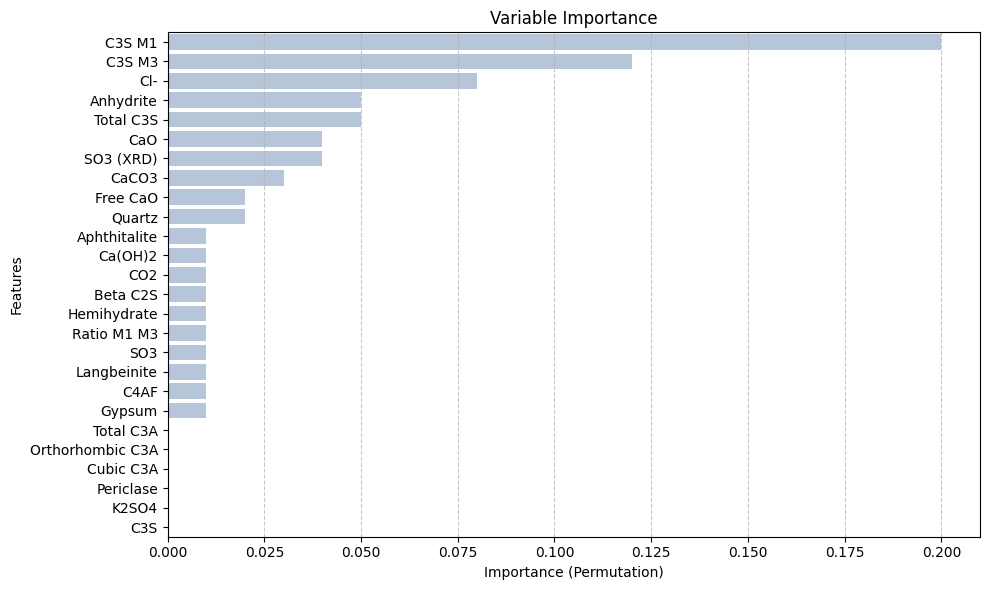

<IPython.core.display.Javascript object>

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort importances
mean_importances_df = importances_df_mean.sort_values(by='Importance', ascending=False).round(2)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=mean_importances_df, color="lightsteelblue")
plt.title("Variable Importance")
plt.xlabel("Importance (Permutation)")
plt.ylabel("Features")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
# plt.savefig(
#     "variable_relevance.png",
#     dpi=300,
#     bbox_inches="tight",
# )
plt.show()


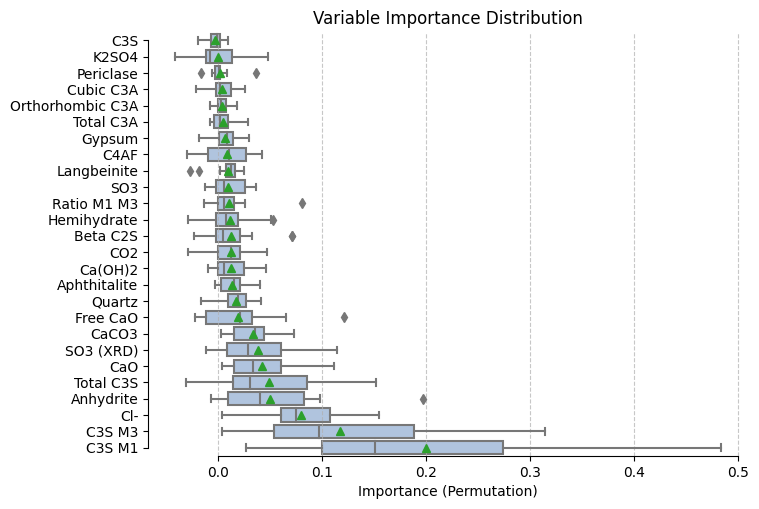

<IPython.core.display.Javascript object>

In [91]:
perm_importances_df = importances_df


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [92]:
perm_importances_df.columns

Index(['C3S', 'K2SO4', 'Periclase', 'Cubic C3A', 'Orthorhombic C3A',
       'Total C3A', 'Gypsum', 'C4AF', 'Langbeinite', 'SO3', 'Ratio M1 M3',
       'Hemihydrate', 'Beta C2S', 'CO2', 'Ca(OH)2', 'Aphthitalite', 'Quartz',
       'Free CaO', 'CaCO3', 'SO3 (XRD)', 'CaO', 'Total C3S', 'Anhydrite',
       'Cl-', 'C3S M3', 'C3S M1'],
      dtype='object')

<IPython.core.display.Javascript object>

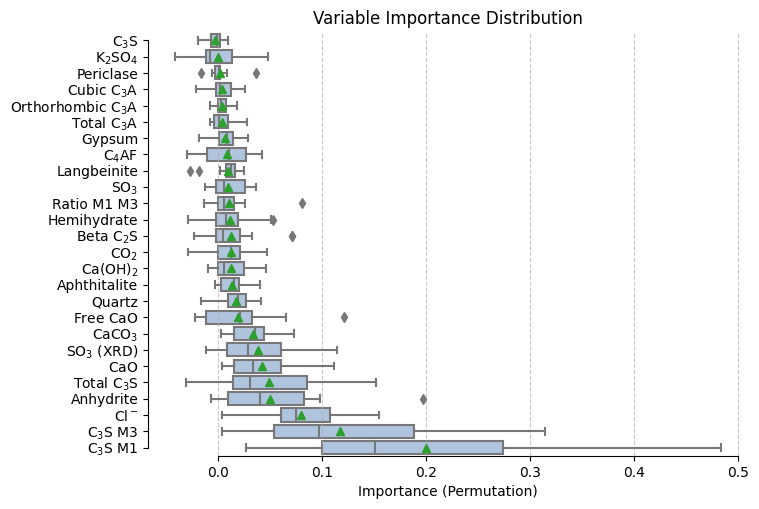

<IPython.core.display.Javascript object>

In [93]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "C3S": r"$\mathrm{C_3S}$",
        "K2SO4": r"$\mathrm{K_2SO_4}$",
        "Periclase": "Periclase",
        "Cubic C3A": r"Cubic $\mathrm{C_3A}$",
        "Orthorhombic C3A": r"Orthorhombic $\mathrm{C_3A}$",
        "Total C3A": r"Total $\mathrm{C_3A}$",
        "Gypsum": "Gypsum",
        "C4AF": r"$\mathrm{C_4AF}$",
        "Langbeinite": "Langbeinite",
        "SO3": r"$\mathrm{SO_3}$",
        "Ratio M1 M3": "Ratio M1 M3",
        "Hemihydrate": "Hemihydrate",
        "Beta C2S": r"Beta $\mathrm{C_2S}$",
        "CO2": r"$\mathrm{CO_2}$",
        "Ca(OH)2": r"$\mathrm{Ca(OH)_2}$",
        "Aphthitalite": "Aphthitalite",
        "Quartz": "Quartz",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "CaCO3": r"$\mathrm{CaCO_3}$",
        "SO3 (XRD)": r"$\mathrm{SO_3}$ (XRD)",
        "CaO": r"$\mathrm{CaO}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "Anhydrite": "Anhydrite",
        "Cl-": r"$\mathrm{Cl}^-$",
        "C3S M3": r"$\mathrm{C_3S}$ M3",
        "C3S M1": r"$\mathrm{C_3S}$ M1",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "inn_cm_tiss_transformer_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

In [94]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
C3S,15.0,-0.002794,0.007629,-0.019639,-0.007277,-0.001277,0.001741,0.009414
K2SO4,15.0,-0.000356,0.025323,-0.041225,-0.011510,-0.007640,0.013633,0.048302
Periclase,15.0,0.001467,0.011197,-0.016983,-0.002849,0.000535,0.001967,0.036073
Cubic C3A,15.0,0.003436,0.013503,-0.021377,-0.001836,0.001847,0.011828,0.026003
Orthorhombic C3A,15.0,0.003595,0.007791,-0.008369,-0.000066,0.002223,0.007402,0.018187
Total C3A,15.0,0.004085,0.009934,-0.008100,-0.004012,0.001218,0.009391,0.028118
Gypsum,15.0,0.006551,0.013669,-0.018384,0.000326,0.008173,0.014318,0.029081
C4AF,15.0,0.008615,0.021187,-0.029583,-0.010328,0.010394,0.027009,0.041747
Langbeinite,15.0,0.008975,0.014196,-0.026900,0.007617,0.012581,0.016197,0.025082
SO3,15.0,0.009790,0.017025,-0.012684,-0.002345,0.005899,0.026090,0.036228


<IPython.core.display.Javascript object>